- Метрикой оценки соревнования на Kaggle является RMSE между логарифмами предсказанных и настоящих значений целевого признака
- Полное описание признаков находится в файле data_description.txt

In [66]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from scipy import stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore') 
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [67]:
def calculate_bounds(data: pd.Series) -> list:
    """
    Вычисляет межквартильный размах (IQR) и определяет границы для выявления выбросов в данных.

    Параметры:
    data (pd.Series): Пандас серия, содержащая данные для расчета.

    Возвращает:
    list: Список, содержащий два элемента:
        - первый элемент - нижняя граница,
        - второй элемент - верхняя граница.

    Описание:
    Функция выполняет следующие шаги:
    1. Вычисляет первый квартиль (Q1), который соответствует 25-му перцентилю данных.
    2. Вычисляет третий квартиль (Q3), который соответствует 75-му перцентилю данных.
    3. Вычисляет межквартильный размах (IQR) как разницу между Q3 и Q1.
    4. Определяет верхнюю границу как Q3 плюс 1.5 * IQR.
    5. Определяет нижнюю границу как Q1 минус 1.5 * IQR.
    6. Возвращает нижнюю и верхнюю границы в виде списка.

    Пример:
    >>> import pandas as pd
    >>> data = pd.Series([10, 12, 14, 15, 15, 16, 17, 18, 19, 20, 22, 24, 25, 30])
    >>> calculate_bounds(data)
    [7.5, 27.5]
    """
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5*iqr
    lower_bound = q1 - 1.5*iqr
    return [lower_bound, upper_bound]

In [68]:
def show_missing_values(data: pd.DataFrame) -> pd.DataFrame:
    """
    Отображает пропущенные значения в данных.

    Параметры:
    data (pd.DataFrame): Пандас датафрейм, содержащий данные для анализа.

    Возвращает:
    pd.DataFrame: Датафрейм, содержащий информацию о пропущенных значениях:
        - Total: Общее количество пропущенных значений для каждого столбца.
        - Percentage: Процент пропущенных значений для каждого столбца.
        - Data Type: Тип данных каждого столбца.

    Описание:
    Функция выполняет следующие шаги:
    1. Создает новый датафрейм `missing_values`.
    2. Рассчитывает общее количество пропущенных значений для каждого столбца и сохраняет в колонку 'Total'.
    3. Вычисляет процент пропущенных значений для каждого столбца и сохраняет в колонку 'Percentage'.
    4. Определяет тип данных для каждого столбца и сохраняет в колонку 'Data Type'.
    5. Сортирует датафрейм по количеству пропущенных значений в порядке убывания.
    6. Возвращает датафрейм с информацией о столбцах, в которых есть пропущенные значения.

    Пример:
    >>> import pandas as pd
    >>> data = pd.DataFrame({'A': [1, 2, None], 'B': [4, None, None], 'C': [7, 8, 9]})
    >>> show_missing_values(data)
       Total  Percentage Data Type
    B      2    0.666667   float64
    A      1    0.333333   float64
    """
    missing_values = pd.DataFrame()
    missing_values['Total'] = data.isnull().sum()
    missing_values['Percentage'] = data.isnull().sum() / len(data)
    missing_values['Data Type'] = data.dtypes
    missing_values = missing_values.sort_values(ascending=False, by=['Total'])
    return missing_values[missing_values['Percentage'] > 0]

In [138]:
def metrics_summary(y_pred, y_true):
    """
    Выводит основные метрики для оценки качества модели.

    Параметры:
    y_pred: Предсказанные значения.
    y_true: Истинные значения.

    Возвращает:
    None

    Описание:
    Функция выполняет следующие шаги:
    1. Вычисляет и выводит корневую среднеквадратическую ошибку (RMSE).
    2. Вычисляет и выводит среднюю абсолютную ошибку (MAE).
    3. Вычисляет и выводит скорректированный коэффициент детерминации (Adj R2).

    Пример:
    >>> y_true = [3, -0.5, 2, 7]
    >>> y_pred = [2.5, 0.0, 2, 8]
    >>> metrics_summary(y_pred, y_true)
    Root Mean Squared Error (RMSE): 0.5
    Mean Absolute Error (MAE): 0.375
    Adjusted R-squared (Adj R2): 0.9486081370449679
    """
    print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("Mean Absolute Error (MAE):", mean_absolute_error(y_true, y_pred))
    print("\033[1mAdjusted R-squared (Adj R2):\033[0m", 1 - (1 - r2_score(y_true, y_pred)) * ((len(y_true) - 1) / (len(y_true) - 43 - 1)))
    return None

In [70]:
def find_best_parameters(X_train, y_train, model):
    """
    Выводит основные метрики для оценки качества модели.

    Параметры:
    y_pred: Предсказанные значения.
    y_true: Истинные значения.

    Возвращает:
    None

    Описание:
    Функция выполняет следующие шаги:
    1. Вычисляет и выводит корневую среднеквадратическую ошибку (RMSE).
    2. Вычисляет и выводит среднюю абсолютную ошибку (MAE).
    3. Вычисляет и выводит скорректированный коэффициент детерминации (Adj R2).

    Пример:
    >>> y_true = [3, -0.5, 2, 7]
    >>> y_pred = [2.5, 0.0, 2, 8]
    >>> metrics_summary(y_pred, y_true)
    Root Mean Squared Error (RMSE): 0.5
    Mean Absolute Error (MAE): 0.375
    Adjusted R-squared (Adj R2): 0.9486081370449679
    """
    parameters = {'n_estimators' : range(200, 1000, 100),
                  'max_depth': range(2, 9, 3)}

    kf = KFold(n_splits=10,
               shuffle=True,
               random_state=42)

    grid_search_cv = GridSearchCV(estimator=model,
                                  param_grid=parameters,
                                  cv=kf,
                                  scoring='neg_root_mean_squared_error',
                                  n_jobs=-1,
                                  verbose=0)

    grid_search_cv.fit(X_train, y_train)
    
    return grid_search_cv.best_estimator_, grid_search_cv.best_params_

In [71]:
sns.set(rc={'figure.figsize' : (9, 6)})
sns.color_palette("pastel")
sns.set_style("ticks") 

In [72]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [73]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [74]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [75]:
print(f"Тренировочная выборка содержит {train_df.shape[0]} строк и {train_df.shape[1]} признак.")
print(f"Тестовая выборка содержит {test_df.shape[0]} строк и {test_df.shape[1]} признаков.")

Тренировочная выборка содержит 1460 строк и 81 признак.
Тестовая выборка содержит 1459 строк и 80 признаков.


In [76]:
submission = pd.DataFrame(test_df['Id'])
train_df.drop('Id', axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

## Пропущенные значения

В первую очередь меня интересует два вопроса:
- Какой процент наблюдений от общего числа пропущен?
- Пропуски в данных случайные или есть какой то паттерн?

Сперва проверю есть ли в обучающей выборке пропущенные значения. Выведу кол-во пропусков, их процент, относительно общего числа наблюдений, и типы данных признаков:

In [77]:
mv_train = show_missing_values(train_df)
mv_train

,Total,Percentage,Data Type
PoolQC,1453,0.995205,object
MiscFeature,1406,0.963014,object
Alley,1369,0.937671,object
Fence,1179,0.807534,object
MasVnrType,872,0.597260,object
FireplaceQu,690,0.472603,object
LotFrontage,259,0.177397,float64
GarageYrBlt,81,0.055479,float64
GarageCond,81,0.055479,object
GarageType,81,0.055479,object


In [78]:
mv_test = show_missing_values(test_df)
mv_test

,Total,Percentage,Data Type
PoolQC,1456,0.997944,object
MiscFeature,1408,0.965045,object
Alley,1352,0.926662,object
Fence,1169,0.801234,object
MasVnrType,894,0.612748,object
FireplaceQu,730,0.500343,object
LotFrontage,227,0.155586,float64
GarageYrBlt,78,0.053461,float64
GarageFinish,78,0.053461,object
GarageQual,78,0.053461,object


В тестовой выборке число пропусков практически такое же для каждого признака, как и для тренировочной, но есть признаки с пропущенными значениями, у которых нет пропусков в тренировочной выборке.

In [79]:
garage_features = train_df[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']]
garage_features[garage_features['GarageYrBlt'].isnull()].head(10)

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,NaN,NaN,NaN,0,0,NaN,NaN
48,NaN,NaN,NaN,0,0,NaN,NaN
78,NaN,NaN,NaN,0,0,NaN,NaN
88,NaN,NaN,NaN,0,0,NaN,NaN
89,NaN,NaN,NaN,0,0,NaN,NaN
99,NaN,NaN,NaN,0,0,NaN,NaN
108,NaN,NaN,NaN,0,0,NaN,NaN
125,NaN,NaN,NaN,0,0,NaN,NaN
127,NaN,NaN,NaN,0,0,NaN,NaN
140,NaN,NaN,NaN,0,0,NaN,NaN


In [80]:
garage_features[garage_features['GarageYrBlt'].isnull()].shape

(81, 7)

In [81]:
bsmt_features = train_df[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']]
bsmt_features[bsmt_features['BsmtFinType2'].isnull()].head(10)

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
17,NaN,NaN,NaN,NaN,0,NaN,0,0,0
39,NaN,NaN,NaN,NaN,0,NaN,0,0,0
90,NaN,NaN,NaN,NaN,0,NaN,0,0,0
102,NaN,NaN,NaN,NaN,0,NaN,0,0,0
156,NaN,NaN,NaN,NaN,0,NaN,0,0,0
182,NaN,NaN,NaN,NaN,0,NaN,0,0,0
259,NaN,NaN,NaN,NaN,0,NaN,0,0,0
332,Gd,TA,No,GLQ,1124,NaN,479,1603,3206
342,NaN,NaN,NaN,NaN,0,NaN,0,0,0
362,NaN,NaN,NaN,NaN,0,NaN,0,0,0


In [82]:
bsmt_features[bsmt_features['BsmtFinType2'].isnull()].shape

(38, 9)

Таким образом, есть следующая ситуация:

- Некоторые признаки(_PoolQC_, _MiscFeature_, _Alley_ и т.д.) практически полностю состоят из пропусков. Я удалю признаки, кол-во пропусков у которых превышает $15$%.
- Признаки Garage__ и Bsmt__ имеют пропуски связанные с отсутствием гаража и подвала(понятно из файла с описанием признаков). Для каждого категориального из этих признаков я создам группу, означающую отсутствие гаража или подвала, для числовых заполню пропуски 0.
- В тренировчной выборке два признака _MasVnrArea_ и _Electrical_ имеют совсем небольшое кол-во пропусков, я удалю эти строки.
- Для тестовой выборки я буду заполнять пропуски, что бы иметь возможность загрузить файл с прогнозом в Kaggle. Буду использовать среднее, медиану или моду в зависимости от ситуации.

In [83]:
train_df.drop(mv_train[mv_train['Percentage'] > 0.15].index, axis=1, inplace=True)
test_df.drop(mv_test[mv_test['Percentage'] > 0.15].index, axis=1, inplace=True)

#### Признаки Garage___:

In [84]:
for column in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train_df[column] = train_df[column].fillna('NoGarage')
    test_df[column] = train_df[column].fillna('NoGarage')

for column in ['GarageCars', 'GarageArea']:
    train_df[column] = train_df[column].fillna(0)
    test_df[column] = train_df[column].fillna(0)

Удаляю признак _GarageYrBlt_ - год постройки гаража, поскольку он не кажется важным(обычно всех интересует год постройки самого дома) и не понятно чем заполнить пропуски у признака-даты.

In [85]:
train_df.drop('GarageYrBlt', axis=1, inplace=True)
test_df.drop('GarageYrBlt', axis=1, inplace=True)

#### Признаки Bsmt___:

In [86]:
for column in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    train_df[column] = train_df[column].fillna('NoBasement')
    test_df[column] = train_df[column].fillna('NoBasement')

for column in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']:
    train_df[column] = train_df[column].fillna(0)
    test_df[column] = train_df[column].fillna(0)

#### Оставшиеся признаки

In [87]:
train_df.dropna(inplace=True)

In [88]:
test_df['MasVnrArea'] = test_df['MasVnrArea'].fillna(test_df['MasVnrArea'].median())
test_df['BsmtHalfBath'] = test_df['BsmtHalfBath'].fillna(0)
test_df['BsmtFullBath'] = test_df['BsmtHalfBath'].fillna(0)

In [89]:
for column in ['MSZoning', 'Utilities', 'Functional', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']:
    test_df[column].fillna(test_df[column].mode()[0], inplace=True)

## EDA

In [90]:
train_df.shape

(1451, 72)

По скольку кол-во предикторов довольно большое(72), я ограничусь частным анализом некоторых, на мой взгляд, важных из них. Но сперва можно просто посмотреть на целевой признак _SalePrice_.

In [91]:
train_df['SalePrice'].describe()

count      1451.000000
mean     180624.101999
std       79312.128273
min       34900.000000
25%      129900.000000
50%      162500.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Целевой признак SalePrice

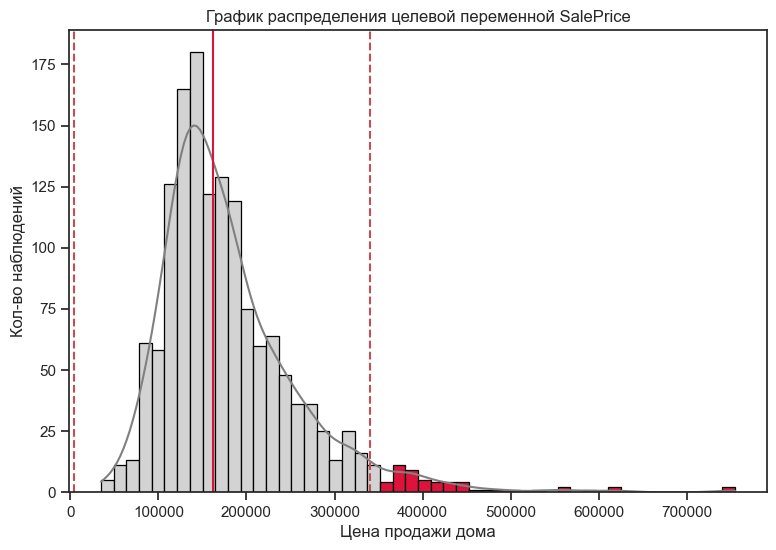

In [92]:
plot = sns.histplot(train_df['SalePrice'], bins=50, kde=True, color='grey', edgecolor='black')

for bar in plot.patches:
    if bar.get_x() <= calculate_bounds(train_df['SalePrice'])[0] or bar.get_x() >= calculate_bounds(train_df['SalePrice'])[1]:
        bar.set_facecolor('crimson')
    else:
        bar.set_facecolor('lightgrey')

plt.xlabel('Цена продажи дома')
plt.ylabel('Кол-во наблюдений')
plt.title('График распределения целевой переменной SalePrice')
plt.axvline(train_df['SalePrice'].median(), color='crimson',label=f"Median Sale Price {train_df['SalePrice'].median()}")
plt.axvline(x=calculate_bounds(train_df['SalePrice'])[0], color='r', linestyle='--')
plt.axvline(x=calculate_bounds(train_df['SalePrice'])[1], color='r', linestyle='--')
plt.show()

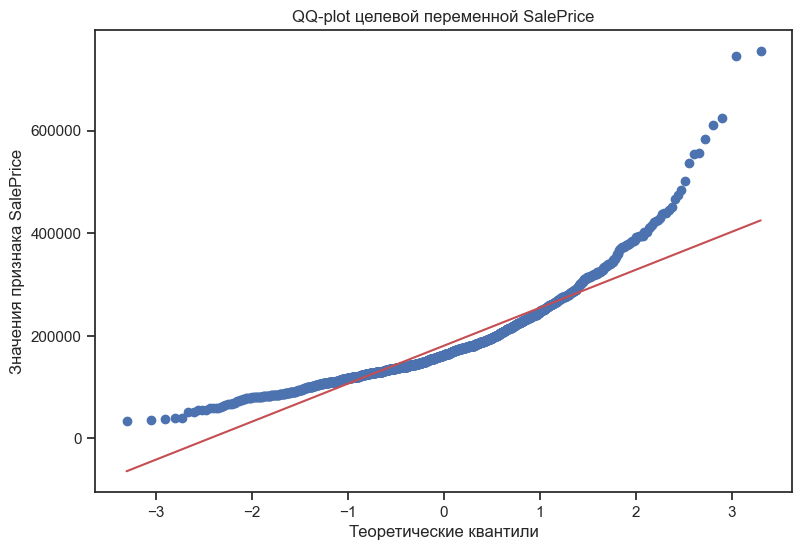

In [93]:
stats.probplot(train_df['SalePrice'], dist="norm", plot=plt)
plt.xlabel('Теоретические квантили')
plt.ylabel('Значения признака SalePrice')
plt.title('QQ-plot целевой переменной SalePrice')
plt.show()

In [94]:
stats.shapiro(train_df['SalePrice'])

ShapiroResult(statistic=0.8697614707862606, pvalue=4.016907678120641e-33)

- Присутствует явная ассиметрия
- Часть значений выходят за полтора межкартильных размаха и являются выбросами
- Распределение статистически отличается от нормального

In [95]:
train_df['LogSalePrice'] = np.log1p(train_df['SalePrice'])

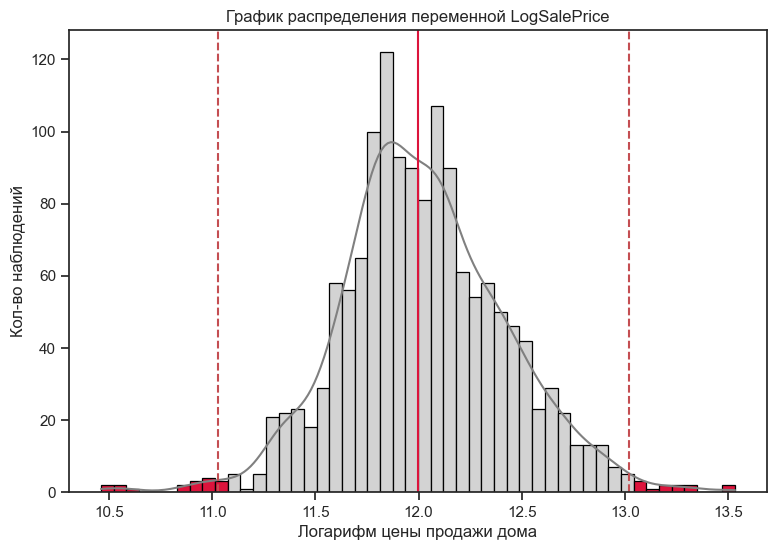

In [96]:
plot = sns.histplot(train_df['LogSalePrice'], bins=50, kde=True, color='grey', edgecolor='black')

for bar in plot.patches:
    if bar.get_x() <= calculate_bounds(train_df['LogSalePrice'])[0] or bar.get_x() >= calculate_bounds(train_df['LogSalePrice'])[1]:
        bar.set_facecolor('crimson')
    else:
        bar.set_facecolor('lightgrey')

plt.xlabel('Логарифм цены продажи дома')
plt.ylabel('Кол-во наблюдений')
plt.title('График распределения переменной LogSalePrice')
plt.axvline(train_df['LogSalePrice'].median(), color='crimson',label=f"Median Sale Price {train_df['LogSalePrice'].median()}")
plt.axvline(x=calculate_bounds(train_df['LogSalePrice'])[0], color='r', linestyle='--')
plt.axvline(x=calculate_bounds(train_df['LogSalePrice'])[1], color='r', linestyle='--')
plt.show()

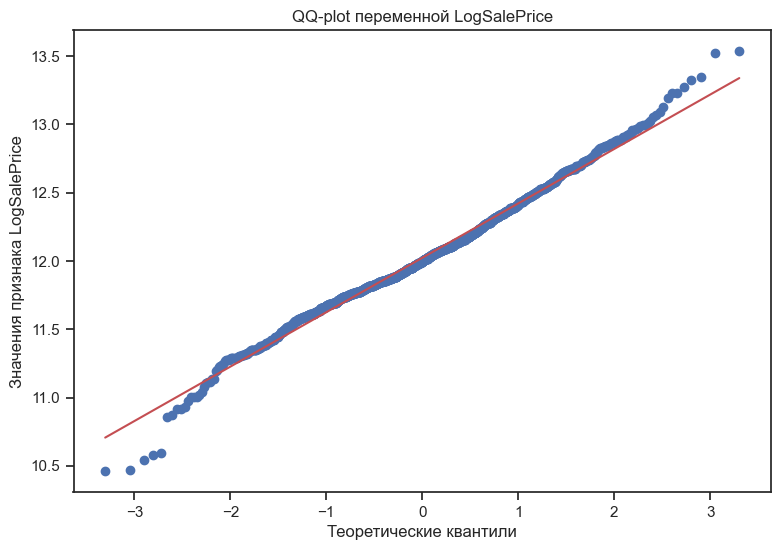

In [97]:
stats.probplot(train_df['LogSalePrice'], dist="norm", plot=plt)
plt.xlabel('Теоретические квантили')
plt.ylabel('Значения признака LogSalePrice')
plt.title('QQ-plot переменной LogSalePrice')
plt.show()

In [98]:
stats.shapiro(train_df['LogSalePrice'])

ShapiroResult(statistic=0.9911284005625718, pvalue=1.1073776834661536e-07)

- Лог-трансформация помогла привести распределение к более нормальному виду
- Несмотря на это, согласно тесту Шапиро-Уилка, распределение все еще статистически отличается от нормального

### Признак GrLivArea

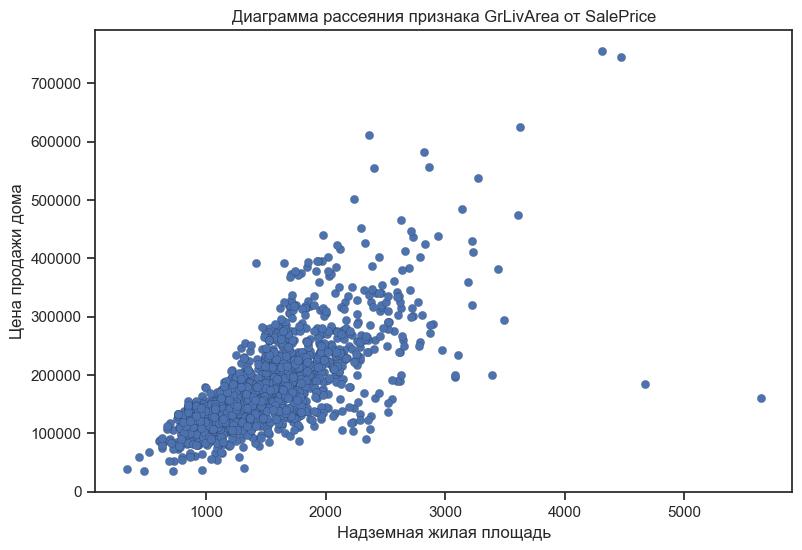

In [99]:
sns.scatterplot(x=train_df['GrLivArea'],
                y=train_df['SalePrice'],
                edgecolor='black',
                linewidth=0.1)
plt.xlabel('Надземная жилая площадь')
plt.ylabel('Цена продажи дома')
plt.title('Диаграмма рассеяния признака GrLivArea от SalePrice')
plt.show()

In [100]:
train_df.drop(train_df[(train_df.GrLivArea > 4000) & (train_df.SalePrice < 300000)].index, axis=0, inplace=True)

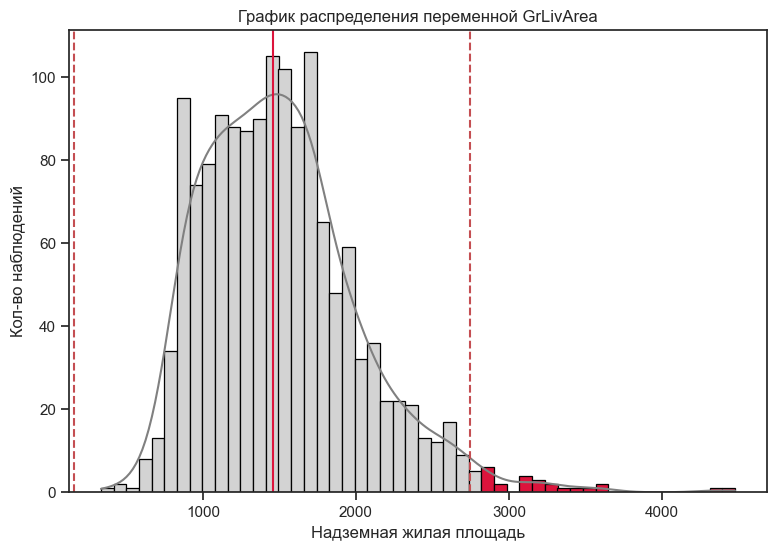

In [101]:
plot = sns.histplot(train_df['GrLivArea'], bins=50, kde=True, color='grey', edgecolor='black')

for bar in plot.patches:
    if bar.get_x() <= calculate_bounds(train_df['GrLivArea'])[0] or bar.get_x() >= calculate_bounds(train_df['GrLivArea'])[1]:
        bar.set_facecolor('crimson')
    else:
        bar.set_facecolor('lightgrey')

plt.xlabel('Надземная жилая площадь')
plt.ylabel('Кол-во наблюдений')
plt.title('График распределения переменной GrLivArea')
plt.axvline(train_df['GrLivArea'].median(), color='crimson',label=f"Median GrLivArea {train_df['GrLivArea'].median()}")
plt.axvline(x=calculate_bounds(train_df['GrLivArea'])[0], color='r', linestyle='--')
plt.axvline(x=calculate_bounds(train_df['GrLivArea'])[1], color='r', linestyle='--')
plt.show()

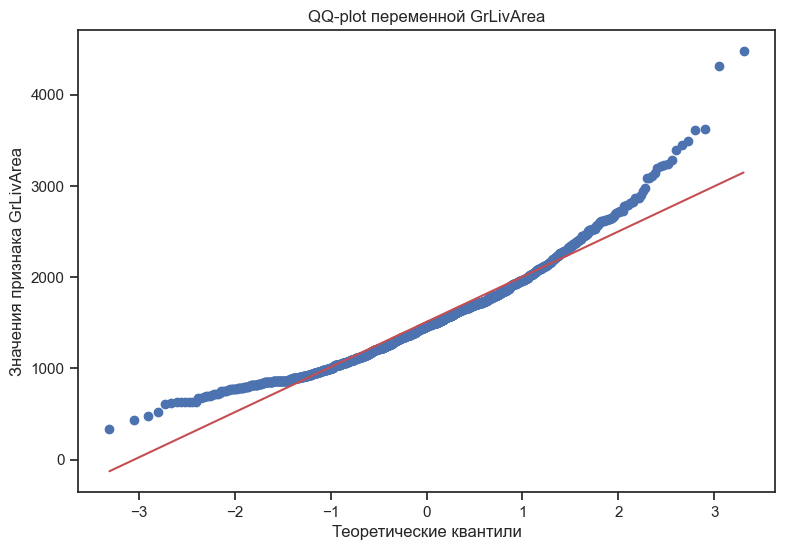

In [102]:
stats.probplot(train_df['GrLivArea'], dist="norm", plot=plt)
plt.xlabel('Теоретические квантили')
plt.ylabel('Значения признака GrLivArea')
plt.title('QQ-plot переменной GrLivArea')
plt.show()

- Есть несколько очень сильных выбросов, где цена за дом низкая, при этом площадь очень большая
- Линейная зависимость с ценой продажи дома
- Снова наблюдается заметная ассиметрия и отклонения от нормального распределения

### Признак TotalBsmtSF

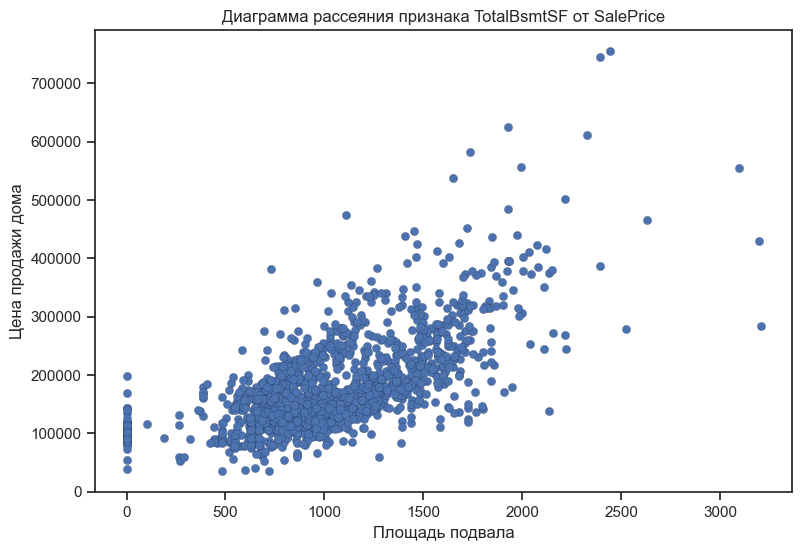

In [103]:
sns.scatterplot(x=train_df['TotalBsmtSF'],
                y=train_df['SalePrice'],
                edgecolor='black',
                linewidth=0.1)
plt.xlabel('Площадь подвала')
plt.ylabel('Цена продажи дома')
plt.title('Диаграмма рассеяния признака TotalBsmtSF от SalePrice')
plt.show()

In [104]:
train_df.drop(train_df[(train_df.TotalBsmtSF > 3000) & (train_df.SalePrice < 500000)].index, axis=0, inplace=True)

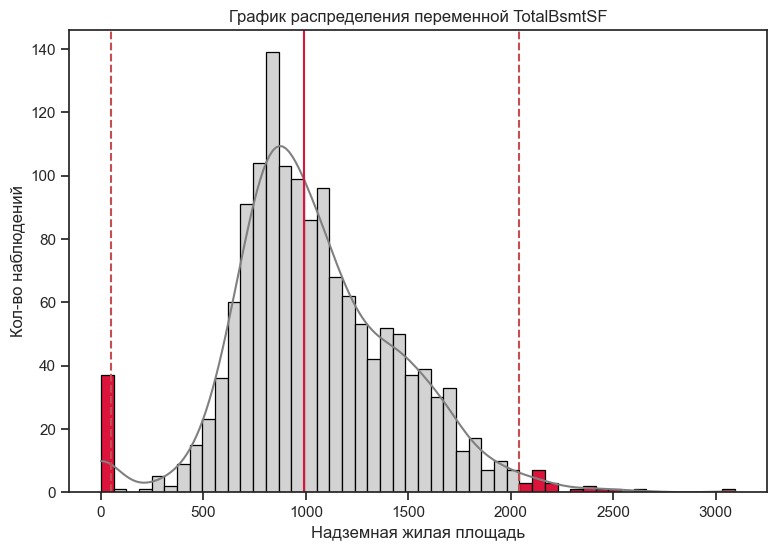

In [105]:
plot = sns.histplot(train_df['TotalBsmtSF'], bins=50, kde=True, color='grey', edgecolor='black')

for bar in plot.patches:
    if bar.get_x() <= calculate_bounds(train_df['TotalBsmtSF'])[0] or bar.get_x() >= calculate_bounds(train_df['TotalBsmtSF'])[1]:
        bar.set_facecolor('crimson')
    else:
        bar.set_facecolor('lightgrey')

plt.xlabel('Надземная жилая площадь')
plt.ylabel('Кол-во наблюдений')
plt.title('График распределения переменной TotalBsmtSF')
plt.axvline(train_df['TotalBsmtSF'].median(), color='crimson',label=f"Median TotalBsmtSF {train_df['TotalBsmtSF'].median()}")
plt.axvline(x=calculate_bounds(train_df['TotalBsmtSF'])[0], color='r', linestyle='--')
plt.axvline(x=calculate_bounds(train_df['TotalBsmtSF'])[1], color='r', linestyle='--')
plt.show()

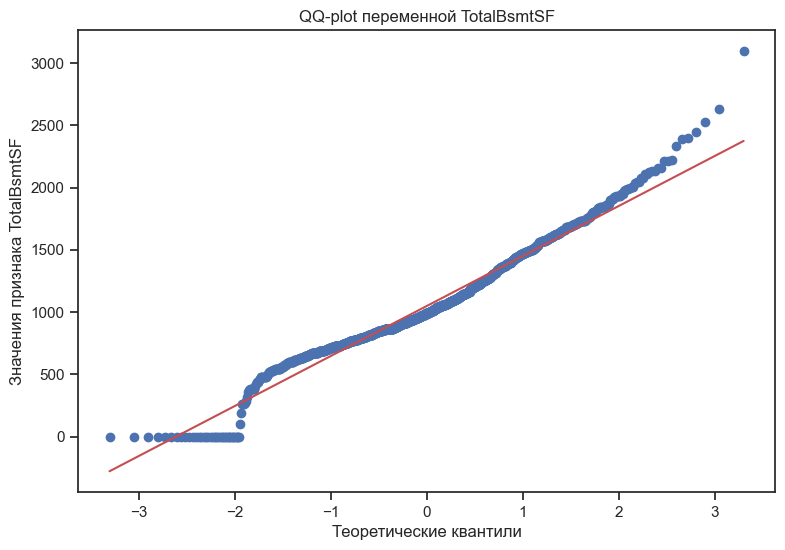

In [106]:
stats.probplot(train_df['TotalBsmtSF'],
               dist="norm",
               plot=plt)
plt.xlabel('Теоретические квантили')
plt.ylabel('Значения признака TotalBsmtSF')
plt.title('QQ-plot переменной TotalBsmtSF')
plt.show()

- Помним, что есть дома без подвалов, поэтому часть значений сконцетрирована в нуле
- Наблюдается определенная линейная зависимость с ценой продажи дома
- Распределение отличается от нормального, присутствуют выбросы

### Признак LotArea

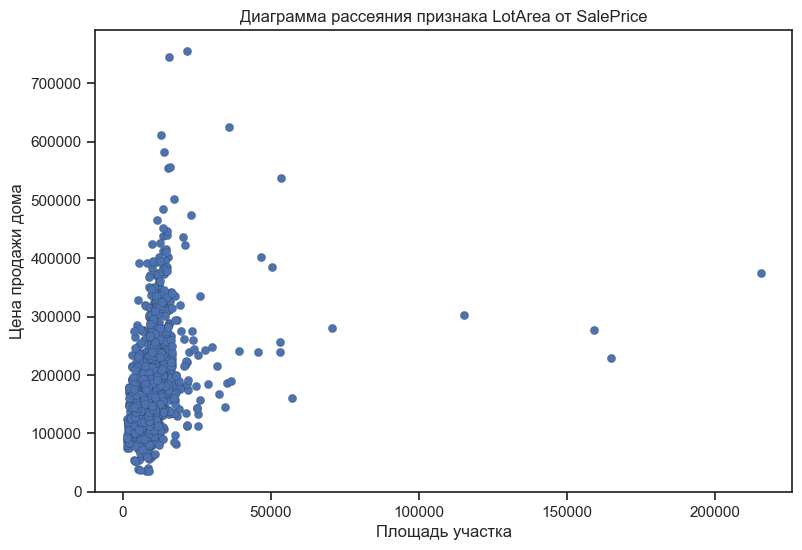

In [107]:
sns.scatterplot(x=train_df['LotArea'],
                y=train_df['SalePrice'],
                edgecolor='black',
                linewidth=0.1)
plt.xlabel('Площадь участка')
plt.ylabel('Цена продажи дома')
plt.title('Диаграмма рассеяния признака LotArea от SalePrice')
plt.show()

In [108]:
train_df.drop(train_df[(train_df.LotArea > 100000) & (train_df.SalePrice < 400000)].index, axis=0, inplace=True)

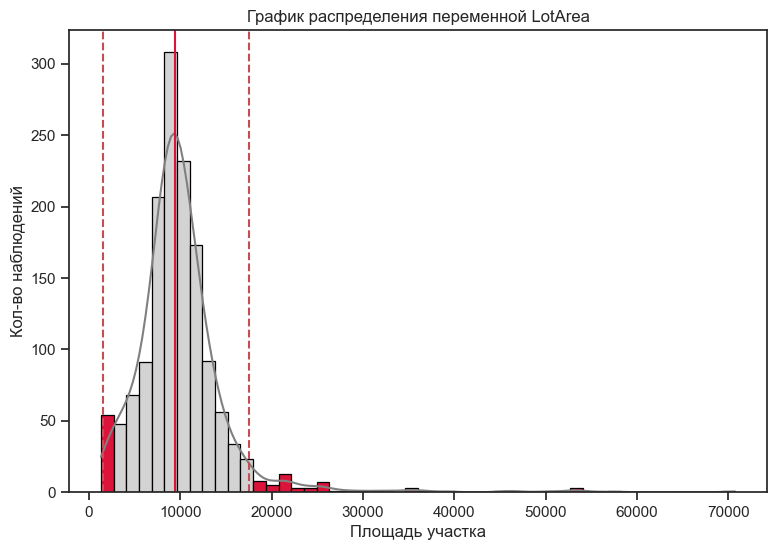

In [109]:
plot = sns.histplot(train_df['LotArea'], bins=50, kde=True, color='grey', edgecolor='black')

for bar in plot.patches:
    if bar.get_x() <= calculate_bounds(train_df['LotArea'])[0] or bar.get_x() >= calculate_bounds(train_df['LotArea'])[1]:
        bar.set_facecolor('crimson')
    else:
        bar.set_facecolor('lightgrey')

plt.xlabel('Площадь участка')
plt.ylabel('Кол-во наблюдений')
plt.title('График распределения переменной LotArea')
plt.axvline(train_df['LotArea'].median(), color='crimson',label=f"Median LotArea {train_df['LotArea'].median()}")
plt.axvline(x=calculate_bounds(train_df['LotArea'])[0], color='r', linestyle='--')
plt.axvline(x=calculate_bounds(train_df['LotArea'])[1], color='r', linestyle='--')
plt.show()

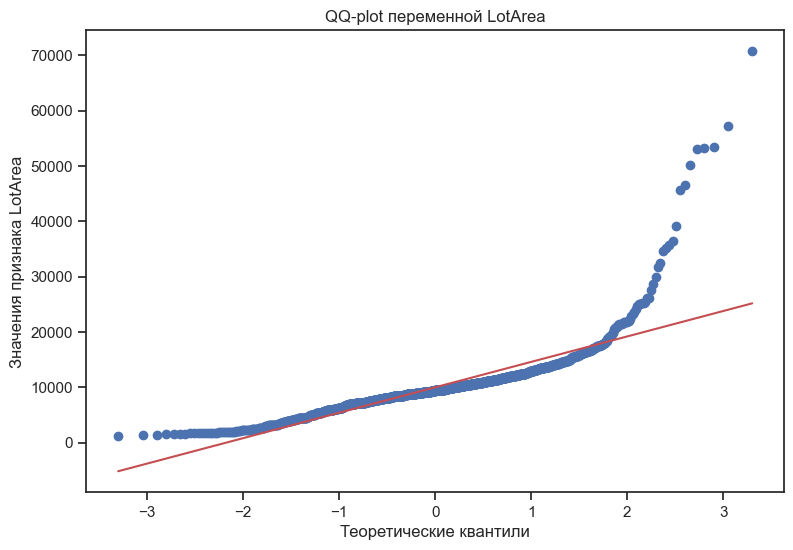

In [110]:
stats.probplot(train_df['LotArea'],
               dist="norm",
               plot=plt)
plt.xlabel('Теоретические квантили')
plt.ylabel('Значения признака LotArea')
plt.title('QQ-plot переменной LotArea')
plt.show()

- Распределение признака сильно отличается от нормального
- Присутствует большое кол-во сильных выбросов
- Исходя из визуальной оценки - линейная зависимость слабая

### Признак OverallQual

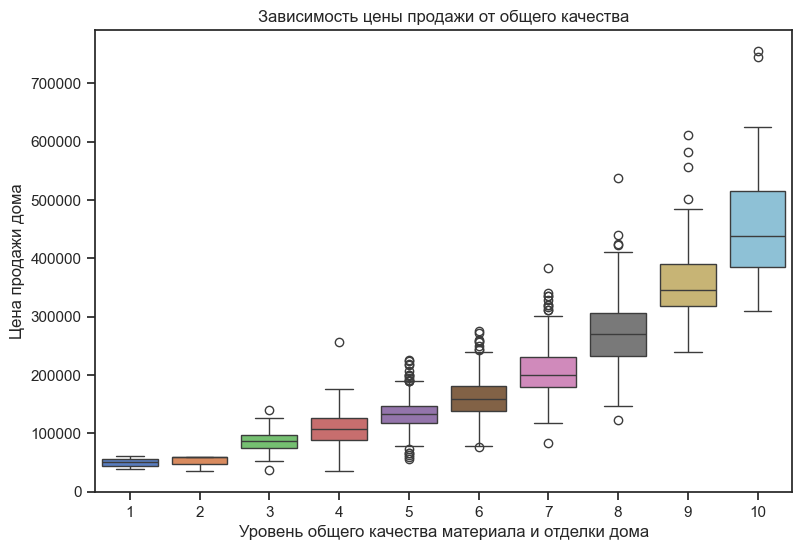

In [111]:
sns.boxplot(x='OverallQual',
            y="SalePrice",
            data=train_df,
            palette='muted')
plt.xlabel('Уровень общего качества материала и отделки дома')
plt.ylabel('Цена продажи дома')
plt.title('Зависимость цены продажи от общего качества')
plt.show()

- Наблюдается определенный тренд, с ростом качества постепенно растет цена дома
- Так же с увеличением качества растет и диапазон цен на дома
- Есть небольшое кол-во выбросов

### Признак ExterQual

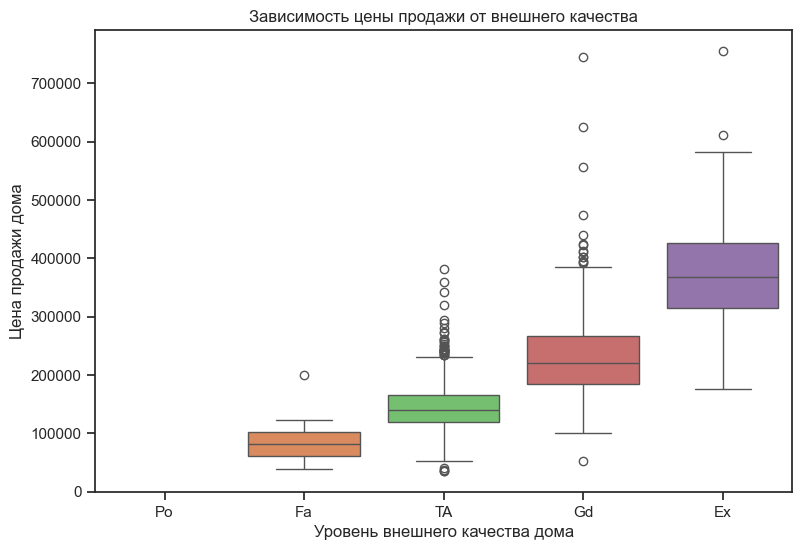

In [112]:
sns.boxplot(x='ExterQual',
            y="SalePrice",
            data=train_df,
            order=['Po', 'Fa', 'TA', 'Gd', 'Ex'],
            palette='muted')
plt.xlabel('Уровень внешнего качества дома')
plt.ylabel('Цена продажи дома')
plt.title('Зависимость цены продажи от внешнего качества')
plt.show()

- Определенно, цена домов растет с увеличением внешнего качества дома
- Диапазон цен так же растет
- Большое кол-во выбросов

### Признак TotRmsAbvGrd

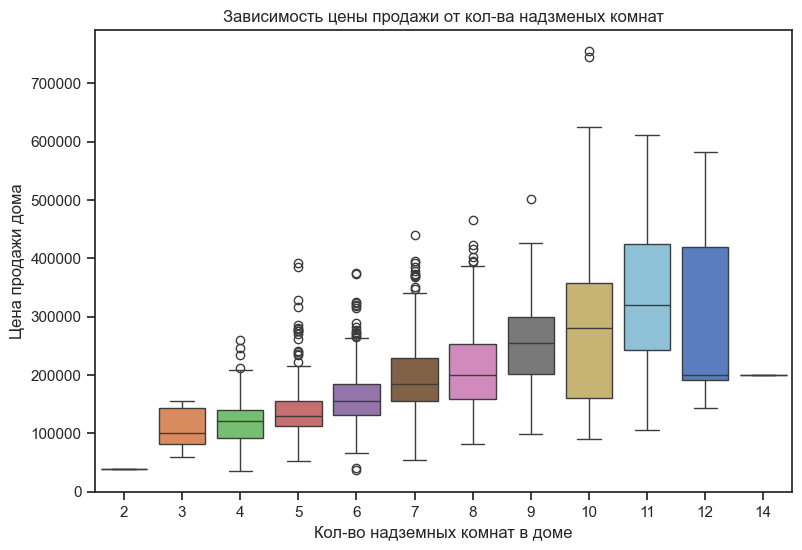

In [113]:
sns.boxplot(x='TotRmsAbvGrd',
            y="SalePrice",
            data=train_df,
            palette='muted')
plt.xlabel('Кол-во надземных комнат в доме')
plt.ylabel('Цена продажи дома')
plt.title('Зависимость цены продажи от кол-ва надзменых комнат')
plt.show()

- Есть положительный линейный тренд, но он не сильно выражен, если отталкиваться от медианного значения
- Диапазон цен сущестенно возрастает при большом кол-ве комнат
- Домов с 2 или 14 комнатами почти нет

### Признак FullBath

- Полные ванные комнаты(англ. Full bathrooms) - ванные комнаты, в которых есть туалет, раковина, ванная и душ

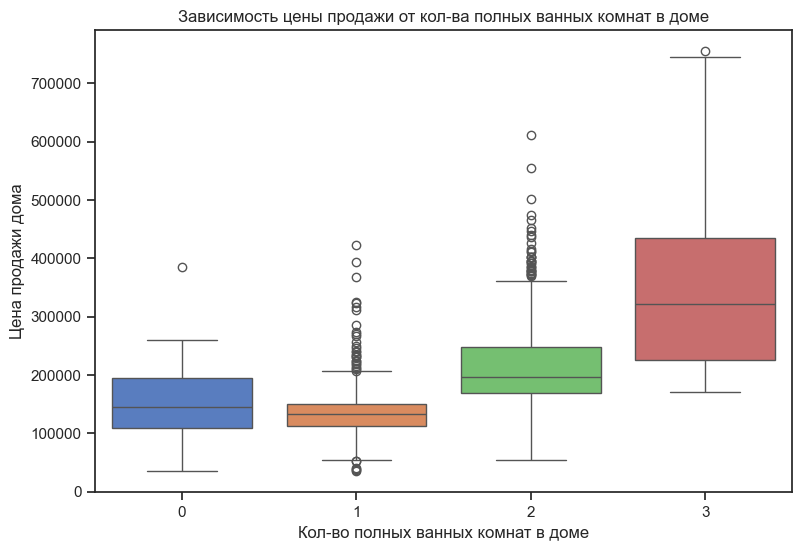

In [114]:
sns.boxplot(x='FullBath',
            y="SalePrice",
            data=train_df,
            palette='muted')
plt.xlabel('Кол-во полных ванных комнат в доме')
plt.ylabel('Цена продажи дома')
plt.title('Зависимость цены продажи от кол-ва полных ванных комнат в доме')
plt.show()

- Можно сказать, что существует слабовыраженная линейная взаимосвязь
- Диапазон цен коллеблется и нельзя сказать, что он постоянно возрастает с увеличением числа комнат

### Признак YearBuilt

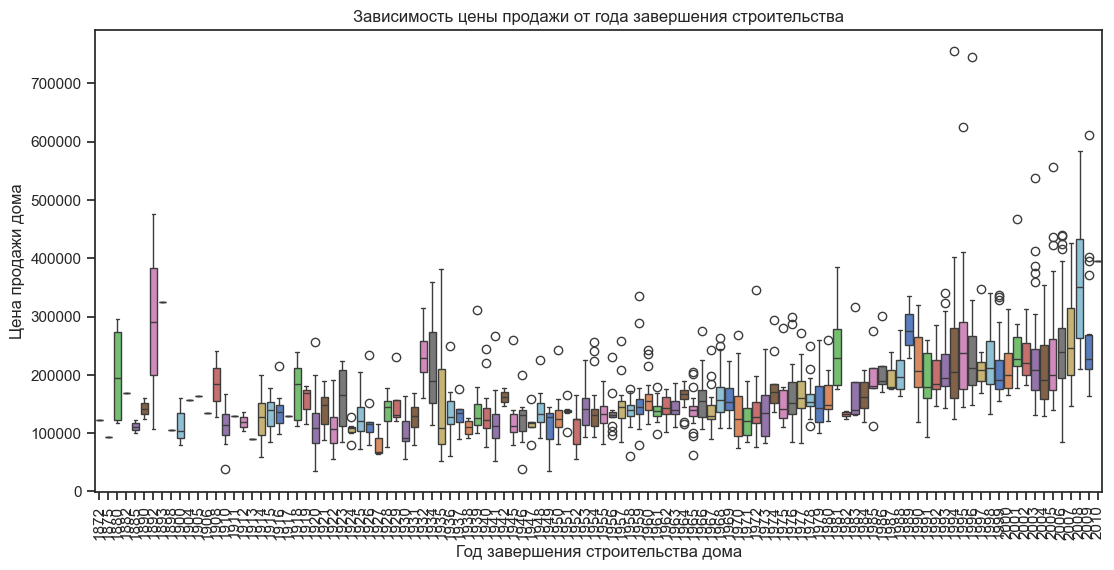

In [115]:
plt.figure(figsize=(13, 6))
sns.boxplot(x='YearBuilt',
            y="SalePrice",
            data=train_df,
            palette='muted')
plt.xlabel('Год завершения строительства дома')
plt.ylabel('Цена продажи дома')
plt.title('Зависимость цены продажи от года завершения строительства')
plt.xticks(rotation=90)
plt.show()

- В целом, наблюдается тенденция к увеличению цен на дома по мере приближения к современным годам
- Распределение цен за каждый год сильно варьируется, что видно по различной высоте ящиков и длине усов на графике

### Кореляционный анализ

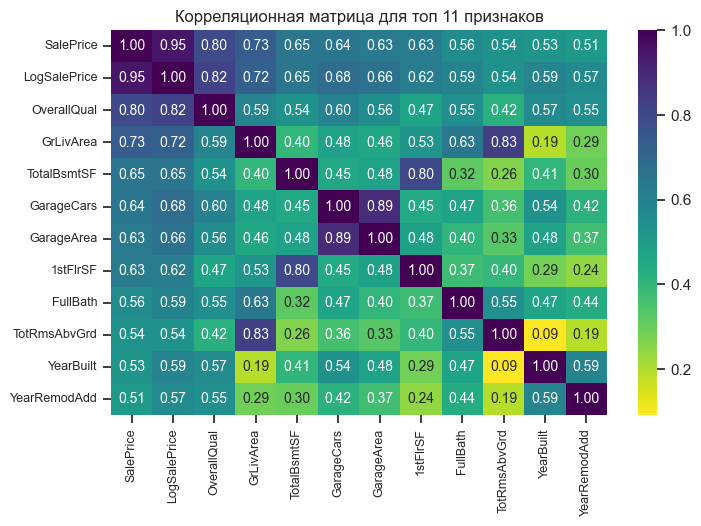

In [116]:
corr_matrix = train_df.corr(numeric_only=True)
corr_with_saleprice = corr_matrix['SalePrice'].abs().sort_values(ascending=False)
top_corr_features = corr_with_saleprice.index[0:12]
plt.figure(figsize=(8, 5))
sns.heatmap(train_df[top_corr_features].corr(), annot=True, cmap='viridis_r', cbar=True, fmt='.2f', annot_kws={'size': 10})
plt.title('Корреляционная матрица для топ 11 признаков')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

- Все представленные признаки имеют достаточно сильную линейную взаимосвязь с _SalePrice_(_LogSalePrice_ не учитывается)
- С другой стороны, очевидно, что присутствует сильная мультиколлинеарность, что ставит под сомнение возможность применения линейной модели для прогнозирования(Но можно попробовать использовать PCA, что бы обойти эту проблему)

## Подготовка данных к моделированию

Перед моделированием признаки необходимо перекодировать

In [117]:
combined_data = pd.concat([train_df, test_df], ignore_index=True)

In [118]:
combined_data.to_csv("data/data_for_transformation.csv", index=False)

In [119]:
show_missing_values(combined_data)

,Total,Percentage,Data Type
LogSalePrice,1459,0.502757,float64
SalePrice,1459,0.502757,float64


**LabelEncoding некоторых категориальных переменных, для которых порядок категорий может быть важен**

In [122]:
label_encoding_cols = ['BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']

for col in label_encoding_cols:
    le = LabelEncoder() 
    le.fit(list(combined_data[col].values)) 
    combined_data[col] = le.transform(list(combined_data[col].values))

**OneHotEncoding оставшихся категориальных переменных**

In [123]:
# one_hot_encoding_cols = ['MSZoning', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood',
#                          'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
#                          'RoofMatl', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating',
#                          'Electrical', 'GarageType', 'SaleType', 'SaleCondition']

In [124]:
combined_data = pd.get_dummies(combined_data)

In [125]:
train_df = combined_data[combined_data['SalePrice'].notna()]
test_df = combined_data[combined_data['SalePrice'].isna()]

test_df = test_df.drop(columns=['SalePrice', 'LogSalePrice'])

In [126]:
print(f"Тренировочная выборка содержит {train_df.shape[0]} строк и {train_df.shape[1]} признак.")
print(f"Тестовая выборка содержит {test_df.shape[0]} строк и {test_df.shape[1]} признаков.")

Тренировочная выборка содержит 1443 строк и 208 признак.
Тестовая выборка содержит 1459 строк и 206 признаков.


**Разбиение данных на выборки**

In [127]:
X = train_df.drop(['SalePrice', 'LogSalePrice'], axis=1)
y = train_df['LogSalePrice']

## Построение модели

In [129]:
rf_reg = RandomForestRegressor()
best_rf_reg, best_rf_params = find_best_parameters(X, y, rf_reg)

In [140]:
print(f'Лучшие параметры модели: {best_rf_params}')

Лучшие параметры модели: {'max_depth': 8, 'n_estimators': 900}


In [139]:
print("Результаты модели случайного леса на тренировочной выборке по основным метрикам: ")
y_pred = best_rf_reg.predict(X)
metrics_summary(y_pred, y)

Результаты модели случайного леса на тренировочной выборке по основным метрикам: 
Root Mean Squared Error (RMSE): 0.07592033608740398
Mean Absolute Error (MAE): 0.05713140027705589
Adjusted R-squared (Adj R2): 0.9625364686117461


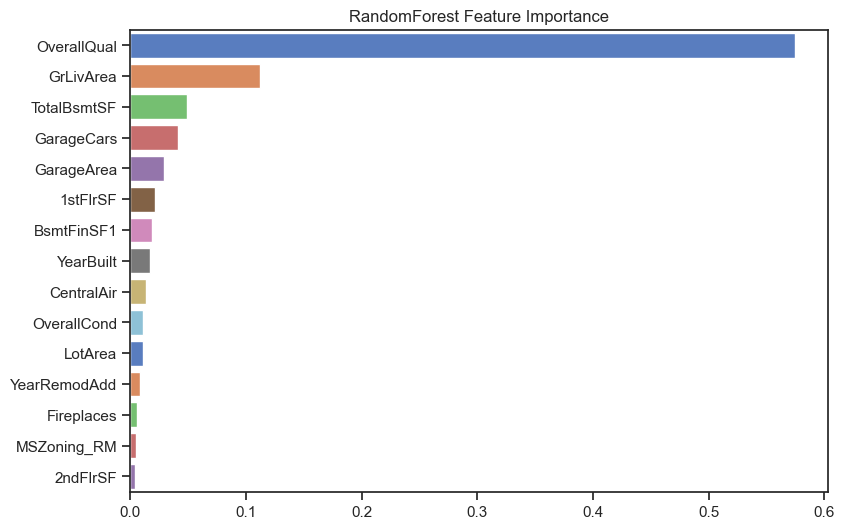

In [135]:
importances = best_rf_reg.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
sns.barplot(feature_importances[:15], orient="h", palette='muted')
plt.title("RandomForest Feature Importance")
plt.show()

In [136]:
submission['SalePrice'] = np.expm1(best_rf_reg.predict(test_df))
submission.to_csv("data/submissions/rf_submission.csv", index=False)

![rf_submission](data/img/rf_submission.png)

## Результаты

- Были обработаны пропущенные значения в наборе данных;
- Проведен визуальный анализ признаков;
- Была построенна модель Случайного леса с использованием кросс-валидации;
- Итоговый показатель RMSE: 0.20747